# Introduction

Convolutional Neural Networks (CNN) are everywhere. It is arguably the most popular deep learning architecture. The main advantage of CNN compared to its predecessors is that it automatically detects the important features without any human supervision. For example, given many pictures of cats and dogs it learns distinctive features for each class by itself.

CNN is also computationally efficient. It uses special convolution and pooling operations and performs parameter sharing. This enables CNN models to run on any device, making them universally attractive.

# Import necessary libraries

In [1]:
# Import necessary libraries
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle
import random
from shutil import copyfile
from random import random, seed
from matplotlib.image import imread

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Directory structure

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


# Unzipping data

In [3]:
# Unzip the train and test data sets
!unzip '../input/dogs-vs-cats/train.zip' -d '/tmp/cats-vs-dogs'
!unzip '../input/dogs-vs-cats/test1.zip' -d '/tmp/cats-vs-dogs'

Archive:  ../input/dogs-vs-cats/train.zip
   creating: /tmp/cats-vs-dogs/train/
  inflating: /tmp/cats-vs-dogs/train/cat.0.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.1.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.100.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.1000.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10000.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10001.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10002.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10003.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10004.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10005.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10006.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10007.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10008.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10009.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.1001.jpg  
  inflating: /tmp/cats-vs-dogs/train/cat.10010.jpg  
  inflating: /tmp/cats-vs-dogs/tra

In [4]:
base_dir = '/tmp/cats-vs-dogs/'

train_dir = '/tmp/cats-vs-dogs/train/'
test_dir = '/tmp/cats-vs-dogs/test1/'

In [5]:
# Creating a dataframe for train set
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

filename  category
0   dog.890.jpg         1
1  dog.1178.jpg         1
2  dog.7845.jpg         1
3  dog.4632.jpg         1
4  cat.3660.jpg         0

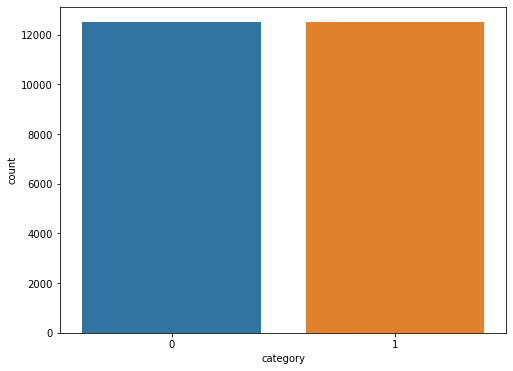

In [7]:
pyplot.figure(figsize=(8,6))
sns.countplot(x='category',data=df)
pyplot.show()

In [8]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

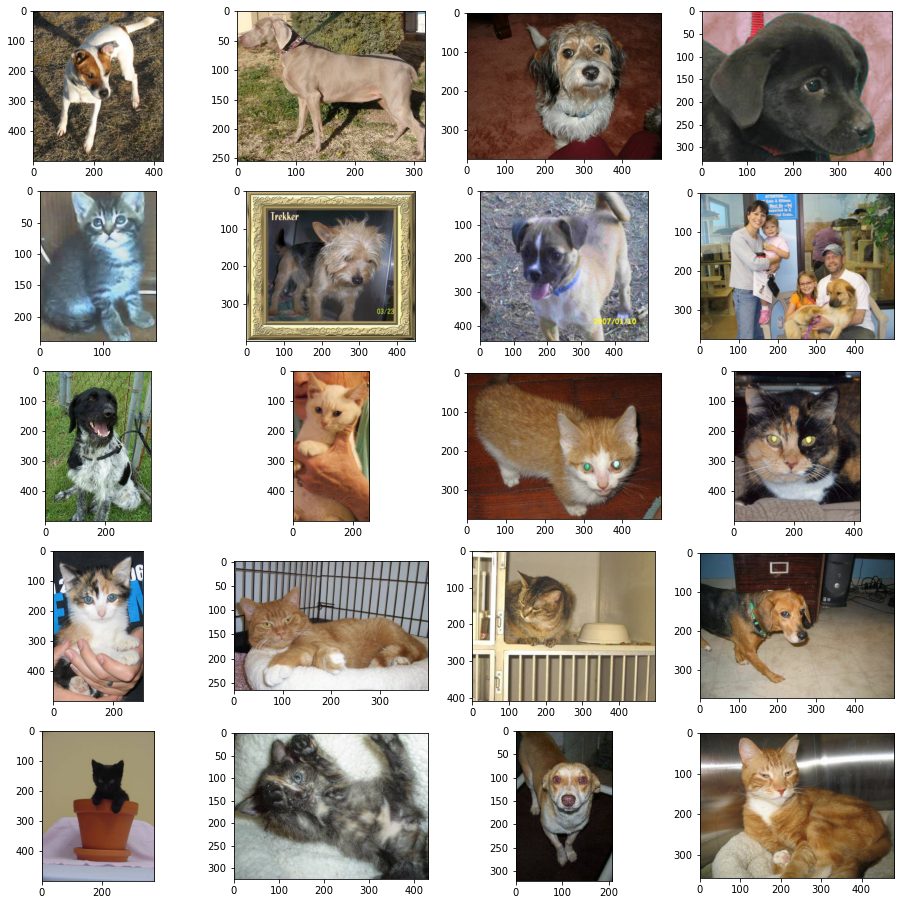

In [9]:
# plot dog photos from the dogs vs cats dataset
fig=pyplot.figure(figsize=(16, 16))
columns = 4
rows = 5
i=1
for filename in os.listdir(train_dir)[0:20]:
    image = imread(train_dir + filename)
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(image)
    i+=1
pyplot.show()

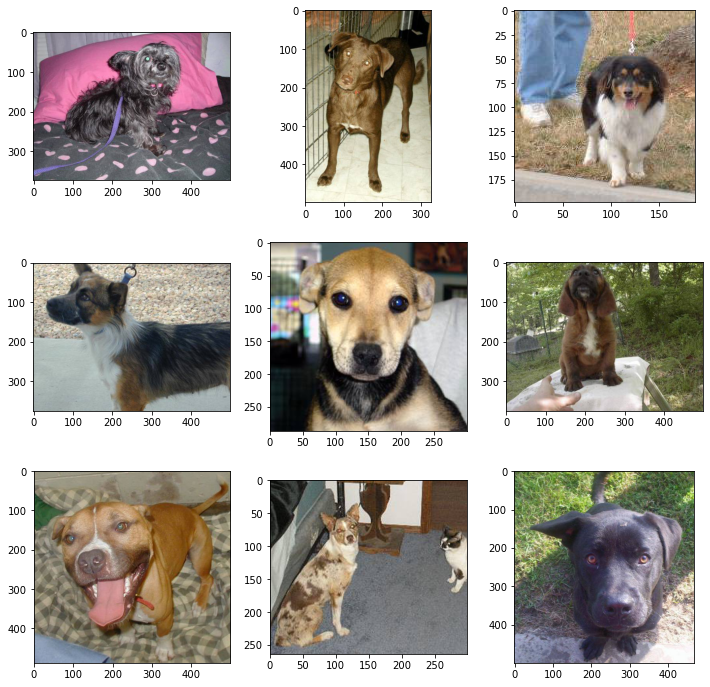

In [10]:
# plot first few dog images
pyplot.figure(figsize=(12,12))
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = train_dir + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

**Highlights**

Running the example creates a figure showing the first nine photos of dogs in the dataset.

We can see that some photos are landscape format, some are portrait format, and some are square.

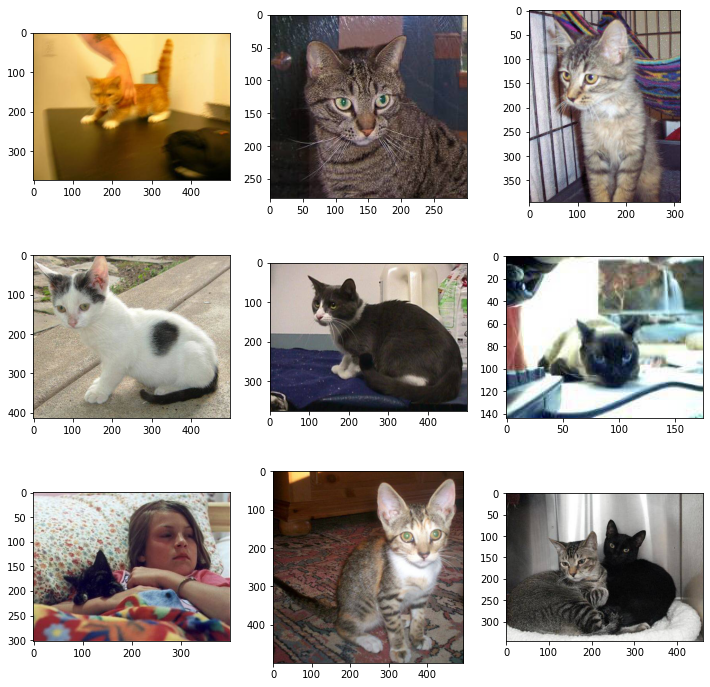

In [11]:
# plot first few cat images
pyplot.figure(figsize=(12,12))
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = train_dir + 'cat.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

**Highlights**

Again, we can see that the photos are all different sizes.

We can also see a photo where the cat is barely visible (bottom left corner) and another that has two cats (lower right corner). This suggests that any classifier fit on this problem will have to be robust.

# Select Standardized Photo Size 
The photos will have to be reshaped prior to modeling so that all images have the same shape. This is often a small square image.

There are many ways to achieve this, although the most common is a simple resize operation that will stretch and deform the aspect ratio of each image and force it into the new shape.

We could load all photos and look at the distribution of the photo widths and heights, then design a new photo size that best reflects what we are most likely to see in practice.

Smaller inputs mean a model that is faster to train, and typically this concern dominates the choice of image size. In this case, we will follow this approach and choose a fixed size of 200×200 pixels.

### Pre-Process Photos into Standard Directories

we can load the images progressively using the **Keras ImageDataGenerator** class and **flow_from_directory()** API.

This API prefers data to be divided into separate training/ and validation/ directories, and under each directory to have a subdirectory for each class, e.g. a training/dogs/ and a training/cats/ subdirectories and the same for validation. Images are then organized under the subdirectories.

We can write a script to create a copy of the dataset with this preferred structure. We will randomly select 25% of the images (or 6,250) to be used in a test dataset.

In [12]:
# create directories
subdirs = ['training/', 'validation/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = base_dir + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [13]:
os.listdir(base_dir)

['validation', 'test1', 'train', 'training']

Next, we can enumerate all image files in the dataset and copy them into the dogs/ or cats/ subdirectory based on their filename.

Additionally, we can randomly decide to hold back 25% of the images into the validation dataset. This is done consistently by fixing the seed for the pseudorandom number generator so that we get the same split of data each time the code is run.

In [14]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in os.listdir(base_dir + src_directory):
    src = base_dir + src_directory + '/' + file
    dst_dir = base_dir + 'training/'
    if random() < val_ratio:
        dst_dir = base_dir + 'validation/'
    if file.startswith('cat'):
        dst =  dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst =  dst_dir + 'dogs/'  + file
        copyfile(src, dst)

In [15]:
# Now, Let's look at the filenames in cats and dogs training and validation directories.
print(os.listdir('/tmp/cats-vs-dogs/training/cats')[0:5])
print(os.listdir('/tmp/cats-vs-dogs/training/dogs')[0:5])
print(os.listdir('/tmp/cats-vs-dogs/validation/cats')[0:5])
print(os.listdir('/tmp/cats-vs-dogs/validation/dogs')[0:5])

['cat.3660.jpg', 'cat.8375.jpg', 'cat.6441.jpg', 'cat.918.jpg', 'cat.1123.jpg']
['dog.1178.jpg', 'dog.7845.jpg', 'dog.4632.jpg', 'dog.814.jpg', 'dog.2066.jpg']
['cat.9803.jpg', 'cat.7264.jpg', 'cat.3255.jpg', 'cat.535.jpg', 'cat.11625.jpg']
['dog.890.jpg', 'dog.1444.jpg', 'dog.5692.jpg', 'dog.3727.jpg', 'dog.6136.jpg']


In [16]:
train_dir = '/tmp/cats-vs-dogs/training/'
valid_dir = '/tmp/cats-vs-dogs/validation/'

# Develop CNN Model

All CNN models follow a similar architecture, as shown in the figure below.

<img src="https://i.imgur.com/zxfn5Sy.png" />

There is an input image that we’re working with. We perform a series convolution + pooling operations, followed by a number of fully connected layers. If we are performing multiclass classification the output is softmax. We will now dive into each component.

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. For example image size is 64x64 = 4096, then it will convert to (4096,1) array.
* **Conv Layer**: The main building block of CNN is the convolutional layer. Convolution is a mathematical operation to merge two sets of information. In our case the convolution is applied on the input data using a convolution filter to produce a feature map.
* **Stride**: Stride specifies how much we move the convolution filter at each step. By default the value is 1.
* **Padding**: We see that the size of the feature map is smaller than the input, because the convolution filter needs to be contained in the input. If we want to maintain the same dimensionality, we can use padding to surround the input with zeros.
* **Pooling Layer**: After a convolution operation we usually perform pooling to reduce the dimensionality. This enables us to reduce the number of parameters, which both shortens the training time and combats overfitting. 
* **Fully Connected Layer**: It connect the network from a layer to another layer. After the convolution + pooling layers we add a couple of fully connected layers to wrap up the CNN architecture.
* **Conv2D**: This method creates a convolutional layer. The first parameter is the filter count, and the second one is the filter size. For example in the first convolution layer we create 32 filters of size 3x3. We use relu non-linearity as activation. We also enable padding. In Keras there are two options for **padding: same or valid**. Same means we pad with the number on the edge and valid means no padding. **Stride** is 1 for convolution layers by default so we don’t change that. 
* **MaxPooling2D**: creates a maxpooling layer, the only argument is the window size. We use a 2x2 window as it’s the most common. By default **stride length is equal to the window size**, which is 2 in our case, so we don’t change that.
* **Flatten**: After the convolution + pooling layers we flatten their output to feed into the fully connected layers as we discussed above.
* **Dropout**: Dropout is by far the most popular **regularization technique** for deep neural networks. Dropout is used to prevent overfitting and the idea is very simple. During training time, at each iteration, a neuron is temporarily “dropped” or disabled with probability p. This means all the inputs and outputs to this neuron will be disabled at the current iteration.
* **Output Layer**: It is the predicted values layer.

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

The model will be fit with stochastic gradient descent and we will start with a conservative learning rate of 0.001 and a momentum of 0.9.

The problem is a binary classification task, requiring the prediction of one value of either 0 or 1. An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy loss function.

In [17]:
# define cnn model

model = Sequential()
    
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', name='conv_1', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', name='conv_2', padding='same'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Dropout(0.2))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', name='conv_3', padding='same'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', name='conv_4', padding='same'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Dropout(0.2))
    
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))
    
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Summary of the Model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 100, 100, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 50, 128)       7

# Data Augmentation
Overfitting happens because of having too few examples to train on, resulting in a model that has poor generalization performance. If we had infinite training data, we wouldn’t overfit because we would see every possible instance. Data augmentation is a way to generate more training data from our current set.

Next, iterators need to be prepared for both the train and test datasets.

We can use the **flow_from_directory()** function on the data generator and create one iterator for each of the training/ and validation/ directories. We must specify that the problem is a binary classification problem via the **class_mode** argument, and to load the images with the size of 200×200 pixels via the **target_size** argument. We will fix the batch size at 64.
This involves first defining an instance of the **ImageDataGenerator** that will scale the pixel values to the range of 0-1.

In [19]:
# Data Augmentation
# datagen = ImageDataGenerator(rescale=1.0/255.0)
    
# # prepare iterator
# train_it = datagen.flow_from_directory(train_dir,class_mode='binary', batch_size=64, target_size=(200, 200))
# valid_it = datagen.flow_from_directory(valid_dir,class_mode='binary', batch_size=64, target_size=(200, 200))

# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
valid_it = valid_datagen.flow_from_directory(valid_dir, class_mode='binary', batch_size=64, target_size=(200, 200))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In this case, photos in the training dataset will be augmented with small (10%)(width_shift_range=0.1) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the training and validation steps will have their pixel values scaled in the same way.

# Callbacks

### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [20]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.001)

In [22]:
callbacks = [earlystop, learning_rate_reduction]

We can then fit the model using the train iterator (train_it) and use the validation iterator (valid_it) as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and test directories divided by the batch size (64).

The model will be fit for 20 epochs, a small number to check if the model can learn the problem.

In [23]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=valid_it, 
                              validation_steps=len(valid_it), epochs=70, callbacks=callbacks, verbose=1) 

Epoch 1/70
293/293 [==============================] - 227s 773ms/step - loss: 0.7415 - accuracy: 0.5032 - val_loss: 0.6928 - val_accuracy: 0.5669
Epoch 2/70
293/293 [==============================] - 227s 776ms/step - loss: 0.6916 - accuracy: 0.5209 - val_loss: 0.6919 - val_accuracy: 0.5640
Epoch 3/70
293/293 [==============================] - 224s 763ms/step - loss: 0.6863 - accuracy: 0.5438 - val_loss: 0.6890 - val_accuracy: 0.5756
Epoch 4/70
293/293 [==============================] - 223s 760ms/step - loss: 0.6852 - accuracy: 0.5468 - val_loss: 0.6900 - val_accuracy: 0.5163
Epoch 5/70
293/293 [==============================] - 222s 756ms/step - loss: 0.6819 - accuracy: 0.5536 - val_loss: 0.6900 - val_accuracy: 0.5080
Epoch 6/70
293/293 [==============================] - 221s 755ms/step - loss: 0.6772 - accuracy: 0.5683 - val_loss: 0.6824 - val_accuracy: 0.6164
Epoch 7/70
293/293 [==============================] - 221s 753ms/step - loss: 0.6749 - accuracy: 0.5674 - val_loss: 0.6860 -

In [24]:
# save model
model.save('final_model.h5')   

# Evaluate model

Once fit, the final model can be evaluated on the validation dataset directly and the classification accuracy reported.

In [25]:
# evaluate model
_, acc = model.evaluate_generator(valid_it, steps=len(valid_it), verbose=1)
print('> %.3f' % (acc * 100.0))

99/99 [==============================] - 18s 183ms/step - loss: 0.4302 - accuracy: 0.8109
> 81.088


Finally, we can create a plot of the history collected during training stored in the **history** directory returned from the call to fit_generator().

The History contains the model accuracy and loss on the validation and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.

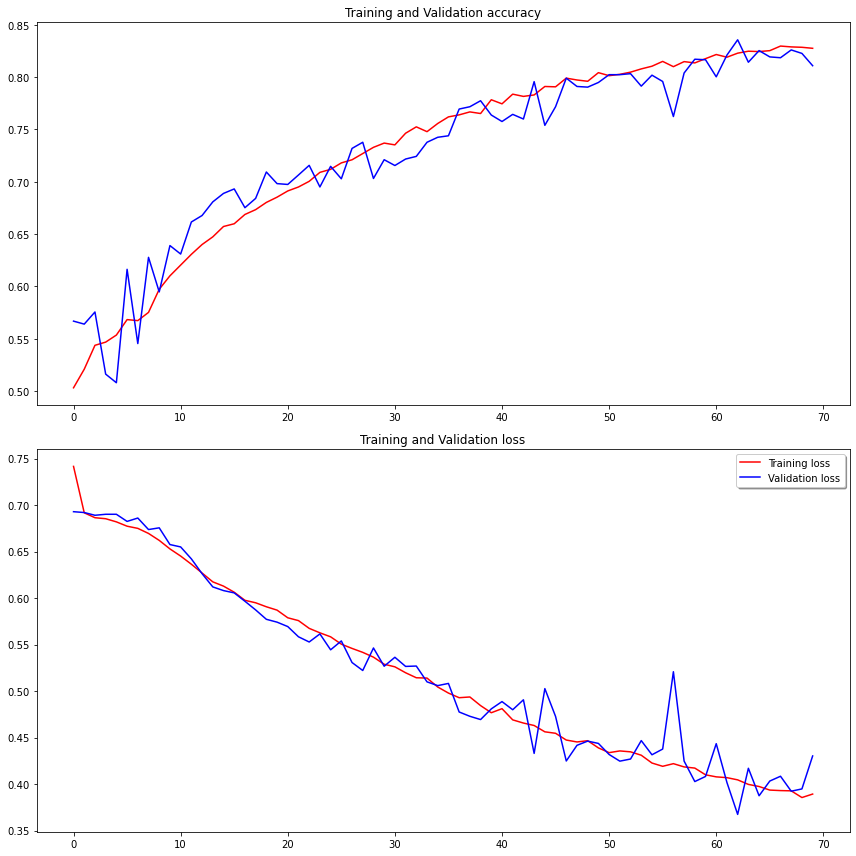

In [26]:
# A figure is also created showing a line plot for the loss and another for the accuracy of the model 
# on both the training (red) and validation (blue) datasets.

# plot diagnostic learning curves
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

fig, (ax1, ax2) = pyplot.subplots(2, 1, figsize=(12, 12))

# plot accuracy
ax1.plot(epochs, acc, "r", label="Training accuracy")
ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
ax1.title.set_text("Training and Validation accuracy")

# plot loss
ax2.plot(epochs, loss, "r", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.title.set_text("Training and Validation loss")

pyplot.legend(loc='best', shadow=True)
pyplot.tight_layout()
pyplot.show()

# Prediction of Testing Data

### Prepare Testing Data

In [27]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [28]:
nb_samples = test_df.shape[0]
nb_samples

12500

In [29]:
test_df.head()

filename
0  10435.jpg
1   6790.jpg
2   4644.jpg
3   1835.jpg
4   1102.jpg

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, test_dir, x_col='filename',y_col=None,class_mode=None,
                                              batch_size=64,target_size=(200, 200),shuffle=False)

Found 12500 validated image filenames.


In [31]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/64))
threshold = 0.6
test_df['category'] = np.where(predict > threshold, 1,0)

In [32]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()

index   filename  category
0   8167   6017.jpg         1
1   9385   4289.jpg         0
2   4067    523.jpg         1
3   5577  11685.jpg         0
4  10764   3424.jpg         0

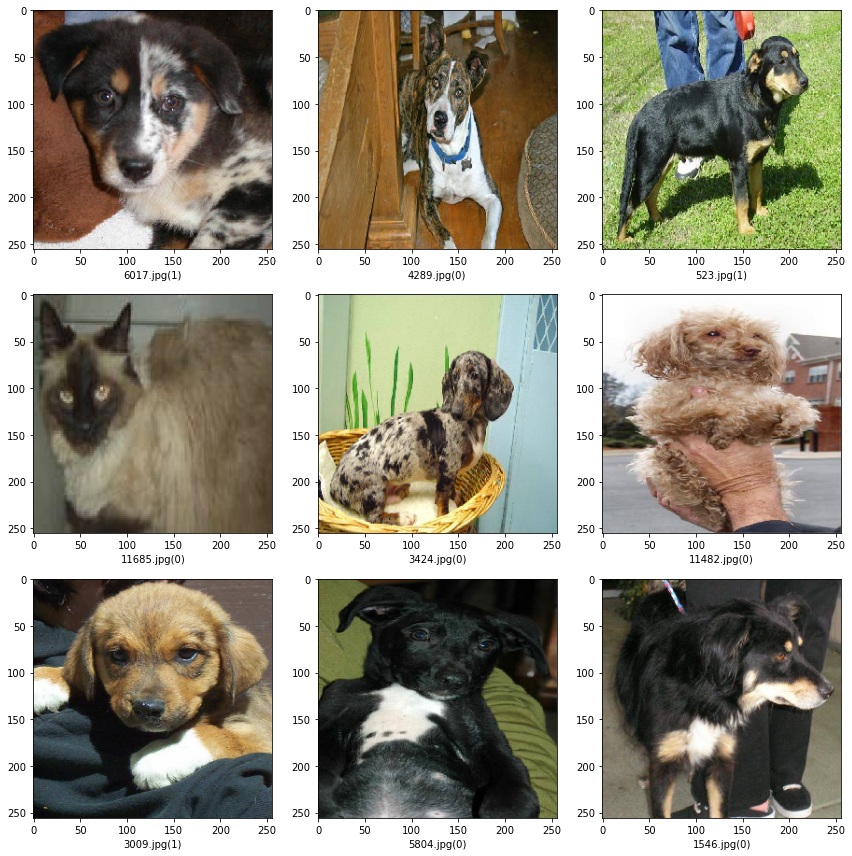

In [33]:
pyplot.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_dir + filename, target_size=(256, 256))
    pyplot.subplot(3, 3, index+1)
    pyplot.imshow(img)
    pyplot.xlabel(filename + '(' + "{}".format(category) + ')')
pyplot.tight_layout()
pyplot.show()

In [34]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

In [35]:
submission_df.to_csv('submission.csv', index=False)

Text(0.5, 1.0, '(Test data)')

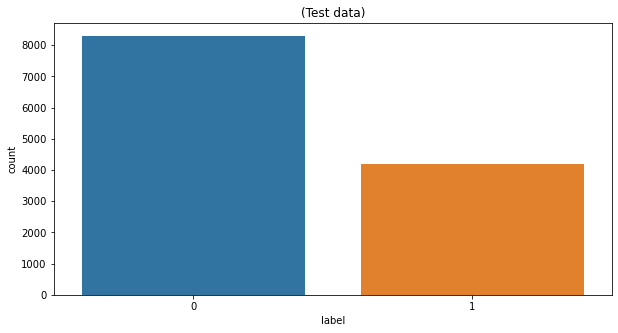

In [36]:
pyplot.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
pyplot.title("(Test data)")